# Tutorial on Feasibility-Driven Trust Region Bayesian Optimization (FuRBO) without restarts

This tutorial shows how to implement Feasibility-Driven Trust Region Bayesian Optimization (FuRBO) [1] with restarts in a closed loop using BoTorch.

In this tutorial, we optimize the 10D Ackley function on the domain $[−5,10]^{10}$ subject to two constraint functions $c_1$ and $c_2$. The problem maximizes the Ackley function while the constraints are fulfilled when $c_1(x) \leq 0$ and $c_2(x) \leq 0$.

[1] P. Ascia, E. Raponi, T. Bäck, and Duddeck, “Feasibility-Driven Trust Region Bayesian Optimization,” presented at the AutoML 2025 Methods Track, 2025. Available: http://arxiv.org/abs/2506.14619 


Since FuRBO is based on Scalable Constrained Bayesian Optimization (SCBO), this tutorial shares part of the same code as the SCBO Tutorial (https://botorch.org/docs/tutorials/scalable_constrained)


### Objective function

Start by defining the 10D Ackley function for evaluation during the optimization loop.

In [170]:
import torch
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize

class ack():
    
    def __init__(self, dim, negate, **tkwargs):
        
        self.fun = Ackley(dim = dim, negate = negate).to(**tkwargs)
        self.fun.bounds[0, :].fill_(-5)
        self.fun.bounds[1, :].fill_(10)
        self.dim = self.fun.dim
        self.lb, self.ub = self.fun.bounds
        
    def eval_(self, x):
        """This is a helper function we use to unnormalize and evalaute a point"""
        return self.fun(unnormalize(x, [self.lb, self.ub]))

### Constraint functions

Define two constraint functions.


1. Constraint $c_1$: enforce the $\sum_{i=1}^{10} x_i \leq T$. We will specify $T=0$ later. 

In [171]:
class sum_():
    def __init__(self, threshold, lb, ub):
        
        self.lb = lb
        self.ub = ub
        self.threshold = threshold
        return 
    
    def c(self, x):
        """This is a helper function we use to unnormalize and evaluate a point"""
        return x.sum() - self.threshold
    
    def eval_(self, x):
        return self.c(unnormalize(x, [self.lb, self.ub]))

2. Constraint $c_2$: enforce the $l_2$ norm $\| \mathbb{x}\|_2 \leq T$. We will specify $T=0.5$ later.

In [172]:
class norm_():
    def __init__(self, threshold, lb, ub):
        
        self.lb = lb
        self.ub = ub
        self.threshold = threshold
        return 
    
    def c(self, x):
        return torch.norm(x, p=2) - self.threshold
    
    def eval_(self, x):
        """This is a helper function we use to unnormalize and evaluate a point"""
        return self.c(unnormalize(x, [self.lb, self.ub]))

### Define FuRBO Class
Define a class to hold the information needed for the optimization loop. 

The state is updated with the samples evaluated at each iteration.  

Prior to the class, two utility functions are defined. The first one identifies the current best sample, while the second one fits a GPR model to the current dataset. 

The ```Furbo_state``` class features a function to reset the status when restarting. Notice that the state is emptied when restarting. Therefore the samples previously evaluated are extracted and saved (see main optimization loop).

In [173]:
import gpytorch
import numpy as np

from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

from scipy.stats import invgauss
from scipy.stats import ecdf

from torch import Tensor

def get_best_index_for_batch(n_tr, Y: Tensor, C: Tensor):
    """Return the index for the best point. One for each trust region.
    For reference, see https://botorch.org/docs/tutorials/scalable_constrained_bo/"""
    is_feas = (C <= 0).all(dim=-1)
    if is_feas.any():  # Choose best feasible candidate
        score = Y.clone()
        score[~is_feas] = -float("inf")
        return torch.topk(score.reshape(-1), k=n_tr).indices
    return torch.topk(C.clamp(min=0).sum(dim=-1), k=n_tr, largest=False).indices # Return smallest violation

def get_fitted_model(X,
                     Y,
                     dim,
                     max_cholesky_size):
    '''Function to fit a GPR to a given set of data.
    For reference, see https://botorch.org/docs/tutorials/scalable_constrained_bo/'''
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0))
    )
    model = SingleTaskGP(
        X,
        Y,
        covar_module=covar_module,
        likelihood=likelihood,
        outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        fit_gpytorch_mll(mll, 
                         optimizer_kwargs={'method': 'L-BFGS-B'})

    return model

from botorch.models.model_list_gp_regression import ModelListGP
from torch.quasirandom import SobolEngine

class Furbo_state():
    '''Class to track optimization status with restart'''
    # Initialization of the status
    def __init__(self,              
                 obj,               # Objective function
                 cons,              # Constraints function
                 batch_size,        # Batch size of each iteration
                 n_init,            # Number of initial points to evaluate
                 n_iteration,       # Number of total iterations
                 **tkwargs):
        
        # Objective function handle
        self.obj = obj
        
        # Constraints function handle
        self.cons = cons
        
        # Domain bounds
        self.lb = obj.lb
        self.ub = obj.ub
        
        # Problem dimensions
        self.batch_size: int = batch_size      # Dimension of the batch at each iteration
        self.n_init: int = n_init              # Number of initial samples
        self.dim: int = obj.dim                # Dimension of the problem
        
        # Trust regions information
        self.tr_ub: float = torch.ones((1, self.dim), **tkwargs)                   # Upper bounds of trust region
        self.tr_lb: float = torch.zeros((1, self.dim), **tkwargs)                  # Lower bounds of trust region
        self.tr_vol: float = torch.prod(self.tr_ub - self.tr_lb, dim=1)            # Volume of trust region
        self.radius: float = 1.0                                                   # Percentage around which the trust region is built
        self.radius_min: float = 0.5**7                                            # Minimum percentage for trust region

        # Trust region updating 
        self.failure_counter: int = 0       # Counter of failure points to asses how algorithm is going
        self.success_counter: int = 0       # Counter of success points to asses how algorithm is going
        self.success_tolerance: int = 2     # Success tolerance for 
        self.failure_tolerance: int = 3     # Failure tolerance for
        
        # Tensor to save current batch information
        self.batch_X: Tensor        # Current batch to evaluate: X values
        self.batch_Y: Tensor        # Current batch to evaluate: Y value
        self.batch_C: Tensor        # Current batch to evaluate: C values
            
        # Stopping criteria information
        self.n_iteration: int = n_iteration     # Maximum number of iterations allowed
        self.it_counter: int = 0                # Counter of iterations for stopping
        self.finish_trigger: bool = False       # Trigger to stop optimization
        self.failed_GP : bool = False           # Flag to pass to failed_GP in FuRBORestart
        
        # Restart criteria information
        self.restart_trigger: bool = False
        
        # Sobol sampler engine
        self.sobol = SobolEngine(dimension=self.dim, scramble=True, seed=1)
        
    # Update the status
    def update(self,
               X_next,          # Samples X (input values) to update the status
               Y_next,          # Samples Y (objective value) to update the status
               C_next,          # Samples C (constraints values) to update the status
               **tkwargs):
        
        '''Function to update optimization status'''
        
        # Merge current batch with previously evaluated samples
        if not hasattr(self, 'X'):
            # If there are no previous samples, declare the Tensors
            self.X = X_next
            self.Y = Y_next
            self.C = C_next
        else:
            # Else, concatenate the new batch to the previous samples
            self.X = torch.cat((self.X, X_next), dim=0)
            self.Y = torch.cat((self.Y, Y_next), dim=0)
            self.C = torch.cat((self.C, C_next), dim=0)

        # update GPR surrogates
        try:
            self.Y_model = get_fitted_model(self.X, self.Y, self.dim, max_cholesky_size = float("inf"))
            self.C_model = ModelListGP(*[get_fitted_model(self.X, C.reshape([C.shape[0],1]), self.dim, max_cholesky_size = float("inf")) for C in self.C.t()])
        except:
            # If update fail, flag to stop entire optimization
            self.failed_GP = True
        
        # Update batch information 
        self.batch_X = X_next
        self.batch_Y = Y_next
        self.batch_C = C_next
            
        # Update best value
        # Find the best value among the candidates
        best_id = get_best_index_for_batch(n_tr=1, Y=self.Y, C=self.C)
            
        # Update success and failure counters for trust region update
        # If attribute 'best_X' does not exist, DoE was just evaluated -> no update on counters
        if hasattr(self, 'best_X'):
            if (self.C[best_id] <= 0).all():
                # At least one new candidate is feasible
                if (self.Y[best_id] > self.best_Y).any() or (self.best_C > 0).any():
                    self.success_counter += 1
                    self.failure_counter = 0                
                else:
                    self.success_counter = 0
                    self.failure_counter += 1
            else:
                # No new candidate is feasible
                total_violation_next = self.C[best_id].clamp(min=0).sum(dim=-1)
                total_violation_center = self.best_C.clamp(min=0).sum(dim=-1)
                if total_violation_next < total_violation_center:
                    self.success_counter += 1
                    self.failure_counter = 0
                else:
                    self.success_counter = 0
                    self.failure_counter += 1
        
        # Update best values
        self.best_X = self.X[best_id]
        self.best_Y = self.Y[best_id]
        self.best_C = self.C[best_id]
        
        # Update iteration counter
        self.it_counter += 1
        
    def reset_status(self,
                     **tkwargs):
        '''Function to reset the status for the restart'''
        
        # Reset trust regions size
        self.tr_ub: float = torch.ones((1, self.dim), **tkwargs)      # Upper bounds of trust region
        self.tr_lb: float = torch.zeros((1, self.dim), **tkwargs)     # Lower bounds of trust region
        self.tr_vol: float = torch.prod(self.tr_ub - self.tr_lb, dim=1)            # Volume of trust region
        self.radius: float = 1.0                                                   # Percentage around which the trust region is built
        self.radius_min: float = 0.5**7                                            # Minimum percentage for trust region

        # Reset counters to change trust region size 
        self.failure_counter: int = 0    # Counter of failure points to asses how algorithm is going
        self.success_counter: int = 0    # Counter of success points to asses how algorithm is going
        
        # Reset restart criteria trigger
        self.restart_trigger: bool = False      # Trigger to restart optimization
        self.failed_GP: bool = False            # Reset GPR failure trigger
        
        # Delete tensors with samples for training GPRs
        if hasattr(self, 'X'):
            del self.X
            del self.Y
            del self.C
        
        # Delete tensors with best value so far
        if hasattr(self, 'best_X'):
            del self.best_X
            del self.best_Y
            del self.best_C
        
        # Clear GPU memory
        if tkwargs["device"] == "cuda":
            torch.cuda.empty_cache()  

### Define trust region

Define a set of functions to evaluate the trust region. First sample according to a Multinormal distribution the GPR surrogates (both objective and constraints). Rank the samples according to both the objective and violation estimation. Take the top $10\%$ of the samples according to the rank. The trust region is defined as a hyperbox enclosing the picked samples. 

In [174]:
def multivariate_circular(centre,       # Centre of the multivariate distribution
                          radius,       # Radius of the multivariate distribution
                          n_samples,    # Number of samples to evaluate
                          lb = None,    # Domain lower bound
                          ub = None,    # Domain upper bound
                          **tkwargs):
    '''Function to generate multivariate distribution of given radius and centre within a given domain.'''
    # Dimension of the design domain
    dim = centre.shape[0]
    
    # Generate a multivariate normal distribution centered at 0
    multivariate_normal = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(dim, **tkwargs), 0.025*torch.eye(dim, **tkwargs))
    
    #  Draw samples torch.distributions.multivariate_normal import MultivariateNormal
    samples = multivariate_normal.sample(sample_shape=torch.Size([n_samples]))
    
    # Normalize each sample to have unit norm, then scale by the radius
    norms = torch.norm(samples, dim=1, keepdim=True)  # Euclidean norms
    normalized_samples = samples / norms  # Normalize to unit hypersphere
    scaled_samples = normalized_samples * torch.rand(n_samples, 1, **tkwargs) * radius  # Scale by random factor within radius
    
    # Translate samples to be centered at centre
    samples = scaled_samples + centre
    
    
    # Trim samples outside domain
    for dim in range(len(lb)):
        samples = samples[torch.where(samples[:,dim]>=lb[dim])]
        samples = samples[torch.where(samples[:,dim]<=ub[dim])]
    
    return samples

def update_tr(state,                # FuRBO state
              percentage = 0.1,     # Percentage to define trust region (default 10%)
              **tkwargs):
    '''Function to sample Multinormal Distribution of GPRs and define trust region'''
    # Update the trust regions based on the feasible region
    n_samples = 1000 * state.dim
    lb = torch.zeros(state.dim, **tkwargs)
    ub = torch.ones(state.dim, **tkwargs)
    
    # Update radius dimension
    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.radius = min(2.0 * state.radius, 1.0)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.radius /= 2.0
        state.failure_counter = 0
    
    for ind, x_candidate in enumerate(state.best_X):
        # Generate the samples to evaluathe the feasible area on
        radius = state.radius
        samples = multivariate_circular(x_candidate, radius, n_samples, lb=lb, ub=ub, **tkwargs)
    
        # Evaluate samples on the models of the objective -> yy Tensor
        state.Y_model.eval()
        with torch.no_grad():
            posterior = state.Y_model.posterior(samples)
            samples_yy = posterior.mean.squeeze()
        
        # Evaluate samples on the models of the constraints -> yy Tensor
        state.C_model.eval()
        with torch.no_grad():
            posterior = state.C_model.posterior(samples)
            samples_cc = posterior.mean
        
        # Combine the constraints values
            # Normalize
        samples_cc /= torch.abs(samples_cc).max(dim=0).values
        samples_cc = torch.max(samples_cc, dim=1).values
        
        # Take the best X% of the drawn samples to define the trust region
        n_samples_tr = int(n_samples * percentage)
        
        # Order the samples for feasibility and for best objective
        if torch.any(samples_cc < 0):
            
            feasible_samples_id = torch.where(samples_cc <= 0)[0]
            infeasible_samples_id = torch.where(samples_cc > 0)[0]
            
            feasible_cc = -1 * samples_yy[feasible_samples_id]
            infeasible_cc = samples_cc[infeasible_samples_id]
            
            feasible_sorted, feasible_sorted_id = torch.sort(feasible_cc)
            infeasible_sorted, infeasible_sorted_id = torch.sort(infeasible_cc)
            
            original_feasible_sorted_indices = feasible_samples_id[feasible_sorted_id]
            original_infeasible_sorted_indices = infeasible_samples_id[infeasible_sorted_id]
            
            top_indices = torch.cat((original_feasible_sorted_indices, original_infeasible_sorted_indices))[:n_samples_tr]
        
        else:
            
            if n_samples_tr > len(samples_cc):
                n_samples_tr = len(samples_cc)
                
            if n_samples_tr < 4:
                n_samples_tr = 4
                
            top_values, top_indices = torch.topk(samples_cc, n_samples_tr, largest=False)
        
        # Set the box around the selected samples
        state.tr_lb[ind] = torch.min(samples[top_indices], dim=0).values
        state.tr_ub[ind] = torch.max(samples[top_indices], dim=0).values
        
        # Update volume of trust region
        state.tr_vol[ind] = torch.prod(state.tr_ub[ind] - state.tr_lb[ind])
        
    # return updated status with new trust regions
    return state

### Sampling strategies

Define a function to generate an initial experimental design using Sobol sampling strategy, similarly to SCBO (https://botorch.org/docs/tutorials/scalable_constrained_bo/).

In [175]:
def get_initial_points(state,
                       **tkwargs):
    '''Function to generate the initial experimental design'''
    X_init = state.sobol.draw(n=state.n_init).to(**tkwargs)
    return X_init

Define a function to identify the best next candidate point, similar to SCBO(https://botorch.org/docs/tutorials/scalable_constrained_bo/).

In [176]:
from botorch.generation.sampling import ConstrainedMaxPosteriorSampling

def generate_batch(state,
                   n_candidates,
                   **tkwargs):
    '''Function to find net candidate optimum'''
    assert state.X.min() >= 0.0 and state.X.max() <= 1.0 and torch.all(torch.isfinite(state.Y))

    # Initialize tensor with samples to evaluate
    X_next = torch.ones((state.batch_size, state.dim), **tkwargs)
    
    # Iterate over the several trust regions

    tr_lb = state.tr_lb[0]
    tr_ub = state.tr_ub[0]

    # Thompson Sampling w/ Constraints (like SCBO)
    pert = state.sobol.draw(n_candidates).to(**tkwargs)
    pert = tr_lb + (tr_ub - tr_lb) * pert

    # Create a perturbation mask
    prob_perturb = min(20.0 / state.dim, 1.0)
    mask = torch.rand(n_candidates, state.dim, **tkwargs) <= prob_perturb
    ind = torch.where(mask.sum(dim=1) == 0)[0]
    mask[ind, torch.randint(0, state.dim - 1, size=(len(ind),), device=tkwargs['device'])] = 1

    # Create candidate points from the perturbations and the mask
    X_cand = state.best_X[0].expand(n_candidates, state.dim).clone()
    X_cand[mask] = pert[mask]
    
    # Sample on the candidate points using Constrained Max Posterior Sampling
    constrained_thompson_sampling = ConstrainedMaxPosteriorSampling(
        model=state.Y_model, constraint_model=state.C_model, replacement=False
        )
    with torch.no_grad():
        X_next[0*state.batch_size:0*state.batch_size+state.batch_size, :] = constrained_thompson_sampling(X_cand, num_samples=state.batch_size)
        
    return X_next

### Stopping criterion

Define a function to detect when the maximum number of iterations is met.

In [177]:
def stopping_criterion(state, n_iteration):
    '''Function to evaluate if the maximum number of allowed iterations is reached.'''
    if state.it_counter <= n_iteration:
        return False
    return True

### Restart criterion

Detect when the GPR fitting process fails to stop the optimization.curve

In [178]:
def GP_restart_criterion(state):
    '''Function to evaluate if a GPR failed during the optimization.'''
    if state.failed_GP:
        print("GPR failed.")
        return True
    return False

Detect when the radius becomes too small.

In [179]:
def restart_criterion(state, radius_min):
    '''Function to evaluate if MND radius is smaller than the minimum allowed radius'''
    if state.radius < radius_min:
        return True
    return False

### Main optimization loop

In [180]:
import warnings

warnings.filterwarnings("ignore")
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
tkwargs = {"device": device, "dtype": dtype}

# Initialize FuRBO
obj = ack(dim = 2,
          negate=True,
          **tkwargs)
cons = list([sum_(threshold = 0,
                  lb = obj.lb,
                  ub = obj.ub), 
             norm_(threshold = 0.5, 
                   lb = obj.lb, 
                   ub = obj.ub)])
batch_size = int(1)#3 * obj.dim)
n_init = int(10)# * obj.dim)
n_iteration = int(100)# * obj.dim)
N_CANDIDATES = 2000

# FuRBO state initialization
FuRBO_status = Furbo_state(obj = obj,                               # Objective function
                                  cons = cons,                      # Constraints function
                                  batch_size = batch_size,          # Batch size of each iteration
                                  n_init = n_init,                  # Number of initial points to evaluate
                                  n_iteration = n_iteration,        # Number of iterations
                                  **tkwargs)

# Initiate lists to save samples over the restarts
X_best, Y_best, C_best = [], [], []
X_all, Y_all, C_all = [], [], []

# Continue optimization the stopping criterions isn't triggered
while not FuRBO_status.finish_trigger: 
    
    # Reset status for restarting
    FuRBO_status.reset_status(**tkwargs)
    
    # generate intial batch of X
    X_next = get_initial_points(FuRBO_status, **tkwargs)
    
    # Reset and restart optimization
    while not FuRBO_status.restart_trigger and not FuRBO_status.finish_trigger:
                
        # Evaluate current batch (samples in X_next)
        Y_next = []
        C_next = []
        for x in X_next:
            # Evaluate batch on obj ...
            Y_next.append(FuRBO_status.obj.eval_(x))
            # ... and constraints
            C_next.append([c.eval_(x) for c in FuRBO_status.cons])
               
        # process vector for PyTorch
        Y_next = torch.tensor(Y_next).unsqueeze(-1).to(**tkwargs)
        C_next = torch.tensor(C_next).to(**tkwargs)
                
        # Update FuRBO status with newly evaluated batch
        FuRBO_status.update(X_next, Y_next, C_next, **tkwargs)   
                
        # Printing current best
        # If a feasible has been evaluated -> print current optimum (feasible sample with best objective value)
        if (FuRBO_status.best_C <= 0).all():
            best = FuRBO_status.best_Y.amax()
            print(f"{FuRBO_status.it_counter-1}) Best value: {best:.2e},"
                  f" MND radius: {FuRBO_status.radius}")
        
        # Else, if no feasible has been evaluated -> print smallest violation (the sample that violatest the least all constraints)
        else:
            violation = FuRBO_status.best_C.clamp(min=0).sum()
            print(f"{FuRBO_status.it_counter-1}) No feasible point yet! Smallest total violation: "
                  f"{violation:.2e}, MND radius: {FuRBO_status.radius}")
            
        # Update Trust regions
        FuRBO_status = update_tr(FuRBO_status,
                                 **tkwargs)
                
        # generate next batch to evaluate 
        X_next = generate_batch(FuRBO_status, N_CANDIDATES, **tkwargs)
        
        # Check if stopping criterion is met (budget exhausted and if GP failed)
        FuRBO_status.finish_trigger = stopping_criterion(FuRBO_status, n_iteration) 
        
        # Check if restart criterion is met
        FuRBO_status.restart_trigger = (restart_criterion(FuRBO_status, FuRBO_status.radius_min) or GP_restart_criterion(FuRBO_status))

    # Save samples evaluated before resetting the status
    X_all.append(FuRBO_status.X)
    Y_all.append(FuRBO_status.Y)
    C_all.append(FuRBO_status.C)

    # Save best sample of this run
    X_best.append(FuRBO_status.best_X)
    Y_best.append(FuRBO_status.best_Y)
    C_best.append(FuRBO_status.best_C)

0) No feasible point yet! Smallest total violation: 5.72e-01, MND radius: 1.0
1) Best value: -1.72e+00, MND radius: 1.0
2) Best value: -1.72e+00, MND radius: 1.0
3) Best value: -7.71e-01, MND radius: 1.0
4) Best value: -7.71e-01, MND radius: 1.0
5) Best value: -7.71e-01, MND radius: 1.0
6) Best value: -2.39e-01, MND radius: 1.0
7) Best value: -2.37e-01, MND radius: 1.0
8) Best value: -2.37e-01, MND radius: 1.0
9) Best value: -8.69e-02, MND radius: 1.0
10) Best value: -8.32e-02, MND radius: 1.0
11) Best value: -8.32e-02, MND radius: 1.0
12) Best value: -8.32e-02, MND radius: 1.0
13) Best value: -8.32e-02, MND radius: 1.0
14) Best value: -8.32e-02, MND radius: 0.5
15) Best value: -8.32e-02, MND radius: 0.5
16) Best value: -2.84e-02, MND radius: 0.5
17) Best value: -2.84e-02, MND radius: 0.5
18) Best value: -2.84e-02, MND radius: 0.5
19) Best value: -2.84e-02, MND radius: 0.5
20) Best value: -2.84e-02, MND radius: 0.25
21) Best value: -2.84e-02, MND radius: 0.25
22) Best value: -2.84e-02,

### Printing result and plotting convergence curve

Print the best-evaluated sample (over all restarts) and the objective value (if a feasible sample was found) or the smallest violation (if no feasible sample was found).

In [181]:
# Print best value found so far
# Ri-elaborate for processing
X_best = torch.stack(X_best).to(**tkwargs)
Y_best = torch.stack(Y_best).to(**tkwargs)
C_best = torch.stack(C_best).to(**tkwargs)

# If a feasible has been evaluated -> print current optimum sample and yielded value
if (C_best <= 0).any():
    best = Y_best.amax()
    bext = X_best[Y_best.argmax()]
    print("Optimization finished \n"
         f"\t Optimum: {best:.2e}, \n"
         f"\t X: {bext}")
    
# Else, if no feasible has been evaluated -> print sample with smallest violation and the violation value
else:
    violation = C_best.sum(dim=2).amin()
    violaxion = X_best[C_best.sum(dim=2).argmin()]
   
    print("Optimization failed \n"
         f"\t Smallest violation: {violation:.2e}, \n"
         f"\t X: {violaxion}")

Optimization finished 
	 Optimum: -1.99e-03, 
	 X: tensor([[0.3333, 0.3333]], dtype=torch.float64)


Plot the monotonic convergence curve

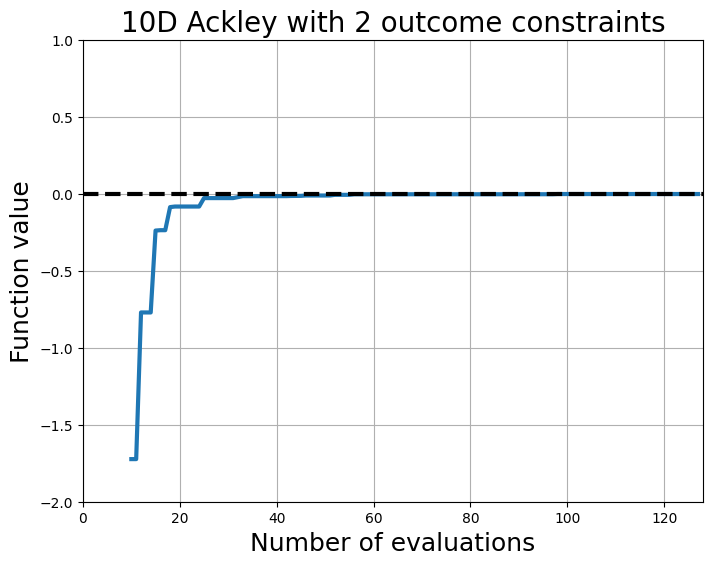

In [189]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

def ensure_tensor(x, tkwargs, dim=0):
    """Helper function to concatenate or convert to tensor to handle potential multiple restarts."""
    if isinstance(x, (list, tuple)):
        # flatten if there's only one element
        if len(x) == 1:
            x = x[0]
        else:
            x = torch.cat([xi if torch.is_tensor(xi) else torch.as_tensor(xi) for xi in x], dim=dim)
    # ensure final type is tensor
    if not torch.is_tensor(x):
        x = torch.as_tensor(x)
    return x.to(**tkwargs)

Y_all = ensure_tensor(Y_all, tkwargs)
C_all = ensure_tensor(C_all, tkwargs)


fig, ax = plt.subplots(figsize=(8, 6))

score = Y_all.clone()
# Set infeasible to -inf
score[~(C_all <= 0).all(dim=-1)] = float("-inf")
fx = np.maximum.accumulate(score.cpu())
plt.plot(fx, marker="", lw=3)

plt.plot([0, len(Y_all)], [obj.fun.optimal_value, obj.fun.optimal_value], "k--", lw=3)
plt.ylabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("10D Ackley with 2 outcome constraints", fontsize=20)
plt.xlim([0, len(Y_all)])
plt.ylim([np.floor(min(fx[(C_all <= 0).all(dim=-1)])), 1])   

plt.grid(True)
plt.show()